In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import os
import glob
import re
import sys
import pickle

from ipywidgets import interact, Dropdown

from photutils.aperture import CircularAperture, aperture_photometry
from spectral_cube import SpectralCube

from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from astropy.constants import c
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec
from astropy.nddata import block_reduce
from astropy.nddata import Cutout2D

home_directory = "/d/ret1/Taylor/jupyter_notebooks/Research" 
os.chdir(home_directory) #TJ change working directory to be the parent directory

from Py_files.Basic_analysis import * #TJ import basic functions from custom package
from Py_files.Convolution_script import * #TJ import convolution functions from custom package
from Py_files.All_flux_calibration_functions import *
with open("Data_files/misc_data/jwst_pivots.pkl", "rb") as file:
    jwst_pivots = pickle.load(file)
with open("Data_files/misc_data/jwst_filter_means.pkl", "rb") as file:
    jwst_means = pickle.load(file)

image_files, filter_files = generate_list_of_files()
locations = [[202.5062429, 47.2143358], [202.4335225, 47.1729608], [202.4340450, 47.1732517], [202.4823742, 47.1958589]]
radius = 1.25*u.arcsec
cut_files = glob.glob('Data_files/IFU_files/raw_IFUs/location_0/F*')
full_raw_ifu_files = ['Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch1-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch2-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch3-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch4-shortmediumlong_s3d.fits']
conv_21um_filter_loc0_ifu_files = glob.glob('Data_files/IFU_files/Convolved_to_21um/test*.fits')
def extract_general_filter_number(filepath):
    match = re.search(r'F(\d+)', filepath)
    return int(match.group(1)) if match else None
conv_21um_filter_loc0_ifu_files = sorted(conv_21um_filter_loc0_ifu_files, key=extract_general_filter_number)

conv_21um_loc0_image_files = glob.glob('Data_files/Image_files/Convolved_images/test*.fits')
conv_21um_loc0_image_files = sorted(conv_21um_loc0_image_files, key=extract_general_filter_number)

'''
wavelength = []
flux = []
for i, file in enumerate(cut_files):
    print(f'adding {i+1}/{len(cut_files)}')
    ifu_data = get_IFU_spectrum(file, locations[0], radius, replace_negatives = False)
    wl = np.array(ifu_data['wavelength'])
    intensity = np.array(ifu_data['intensity'])
    if i == 0:
        wavelength = wl
        flux = intensity
    else:
        wavelength = np.concatenate([wavelength, wl])
        flux = np.concatenate([flux, intensity])
    
np.save('Data_files/misc_data/full_raw_loc0_data.npy', [wavelength, flux])
'''
print()


In [112]:
#TJ this cell recreates full spectrum with varying anchor indices. Does not need to be re-run
'''for anchor in range(31):
    data = stitch_spectra(conv_21um_filter_loc0_ifu_files, locations[0], radius, replace_negatives = False, anchor_idx = anchor)
    wavelength = data['wavelength']
    flux = data['intensity']
    array = np.array([wavelength, flux])
    np.save(f'Data_files/misc_data/Updated_flux_calibration/loc0_rad1p25_conv21_anchor{anchor}.npy', array)
    print(wavelength[0], wavelength[-1])'''
print()
for filter_file in filter_files:
    filter_name = extract_filter_name(filter_file).upper()
    print(filter_name, which_conv_fits(filter_name))


F115W ['Data_files/IFU_files/Convolved_to_21um/test_F115W_IFU30_convolved_to_21um.fits', 'Data_files/IFU_files/Convolved_to_21um/test_F140M_IFU29_convolved_to_21um.fits', 'Data_files/IFU_files/Convolved_to_21um/test_F150W_IFU28_convolved_to_21um.fits']
F140M ['Data_files/IFU_files/Convolved_to_21um/test_F115W_IFU30_convolved_to_21um.fits', 'Data_files/IFU_files/Convolved_to_21um/test_F140M_IFU29_convolved_to_21um.fits', 'Data_files/IFU_files/Convolved_to_21um/test_F150W_IFU28_convolved_to_21um.fits']
F150W ['Data_files/IFU_files/Convolved_to_21um/test_F115W_IFU30_convolved_to_21um.fits', 'Data_files/IFU_files/Convolved_to_21um/test_F140M_IFU29_convolved_to_21um.fits', 'Data_files/IFU_files/Convolved_to_21um/test_F150W_IFU28_convolved_to_21um.fits', 'Data_files/IFU_files/Convolved_to_21um/test_F164N_IFU27_convolved_to_21um.fits', 'Data_files/IFU_files/Convolved_to_21um/test_F182M_IFU26_convolved_to_21um.fits', 'Data_files/IFU_files/Convolved_to_21um/test_F200W_IFU24_convolved_to_21um.f

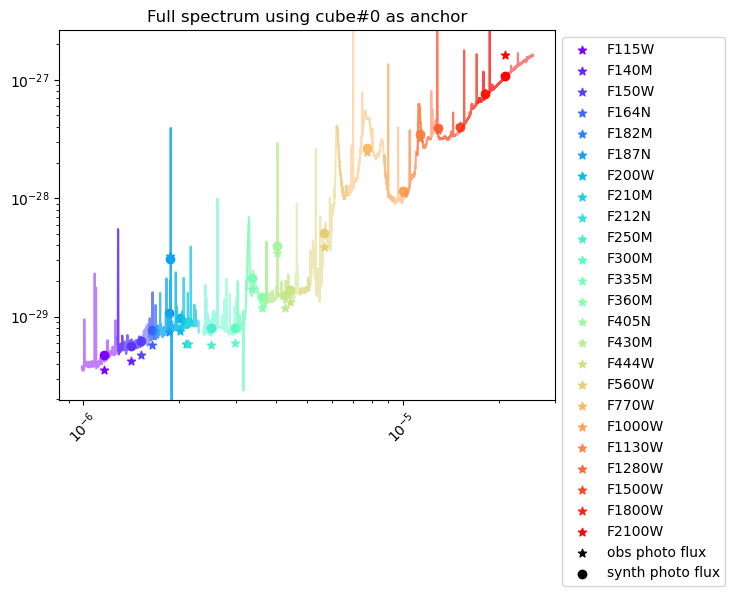

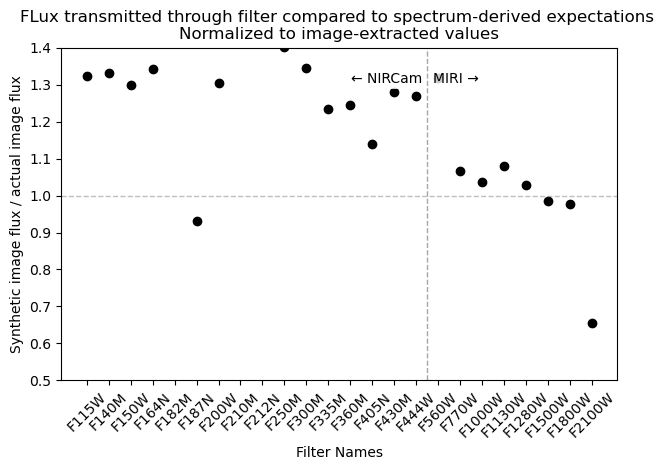

KeyboardInterrupt: 

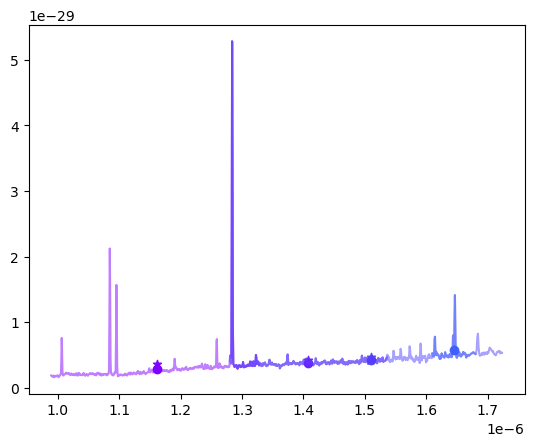

In [108]:
def which_raw_fits(filter_name):
    '''return which raw files are at least partially contained within this filter
    
    -------------
    
    Parameters
    -------------
    filter_name : type = string - upper case filter name

    Returns
    -------------
    list of raw ifu files
    '''   
    needed = []
    low, high = [x.value for x in get_filter_wl_range(filter_name)]
    for file in full_raw_ifu_files:
        wl = SpectralCube.read(file, hdu = 'SCI').spectral_axis.to(u.m).value
        if (wl[-1] >= low and wl[0] <= high):
            needed.append(file)
    return needed

def which_conv_fits(filter_name):
    '''return which raw files are at least partially contained within this filter
    
    -------------
    
    Parameters
    -------------
    filter_name : type = string - upper case filter name

    Returns
    -------------
    list of raw ifu files
    '''   
    needed = []
    low, high = [x.value for x in get_filter_wl_range(filter_name)]
    for file in conv_21um_filter_loc0_ifu_files:
        wl = SpectralCube.read(file, hdu = 'SCI').spectral_axis.to(u.m).value
        if (wl[-1] >= low and wl[0] <= high):
            needed.append(file)
    return needed
        
def show_data_for_anchored_images(full_spectrum, image_files, loc, radius):
    '''show spectrum with overlayed photo and synth flux calculations
    
    -------------
    
    Parameters
    -------------
    full_spectrum : type = array - Array of [wavelengths, fluxes], must cover the wavelengths of the image_files
    image_files : type = list - list of photo files from which to extract filter bandpass fluxes
    loc : type = either [ra, dec] in degrees, or a SkyCoord object - location of center of the aperture
    radius : type = angular size - radius of aperture, must have units attached.

    Returns
    -------------
    Just plots
    '''   
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    cmap = cm.get_cmap('rainbow', len(image_files))
    colors = [cmap(i) for i in range(len(image_files))]
    for i, file in enumerate(image_files):
        try:
            filter_name = extract_general_filter_number(file)
        except:
            print(f'filter name not found in image file {image_file}')            
            continue
        
        

def show_spectra_from_ifus(list_of_IFUs, loc, radius, show_plot=True, figax=None):
    '''Plots spectrum of provided IFUs, helps verify that stitching is consistent
    
    -------------
    
    Parameters
    -------------
    list_of_IFUs : type = list - list of IFU files to be stitched together and plotted
    list_of_photos : type = list - list of photo files from which to extract filter bandpass fluxes
    loc : type = either [ra, dec] in degrees, or a SkyCoord object - location of center of the aperture
    radius : type = angular size - radius of aperture, must have units attached.

    Returns
    -------------
    Just plots
    '''   
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    cmap = cm.get_cmap('rainbow', len(list_of_IFUs))
    colors = [cmap(i) for i in range(len(list_of_IFUs))]
    for i, file in enumerate(list_of_IFUs):
        print(f'Adding data from file:{i+1}/{len(list_of_IFUs)}')
        ifu_data = get_IFU_spectrum(file, loc, radius, replace_negatives = False)
        ax.plot(ifu_data['wavelength'], ifu_data['intensity'], color = colors[i], label = file.split("/")[-1].split("_")[0])
    ax.set_title('Spectra of multiple files')
    ax.set_xlabel("Wavelength (m)")
    ax.set_ylabel("Flux (MJy/sr)")

    ax.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
    if show_plot:
        plt.show()
    return fig, ax
    
def show_spec_and_all_filters(list_of_IFUs, list_of_photos, loc, radius):
    '''Plots spectrum and overplots the observed flux through filters within that spectrum's range.
    -------------
    
    Parameters
    -------------
    list_of_IFUs : type = list - list of IFU files to be stitched together and plotted
    list_of_photos : type = list - list of photo files from which to extract filter bandpass fluxes
    loc : type = either [ra, dec] in degrees, or a SkyCoord object - location of center of the aperture
    radius : type = angular size - radius of aperture, must have units attached.

    Returns
    -------------
    Nothing, just plots
    '''   
    y_min = 1
    y_max = 0
    cmap = cm.get_cmap('rainbow', len(list_of_photos))
    colors = [cmap(i) for i in range(len(list_of_photos))]
    filter_names = []
    y_data = []
    for p, photo_file in enumerate(list_of_photos):
        try:
            filter_name = extract_filter_name(photo_file).upper()
        except:
            filter_name = photo_file.split('/')[-1].split('_')[1]
        filter_names.append(filter_name)
        #filter_name = photo_file.split('/')[-1].split('_')[1]
        filter_file = [flt for flt in filter_files if extract_filter_name(flt).upper() == filter_name][0]
        filter_data = []
        with open(filter_file, 'r') as f:
            header = f.readline().strip().split()
            for line in f:
                data_line = line.strip().split()
                filter_data.append(data_line)
        if len(filter_data) < 2:
            print(f"Filter file {filter_file} seems empty or malformed.")
    
        header, filter_T = filter_data[:2], np.array(filter_data[2:])
        filter_wl = np.array([try_float(row[0]) * 1e-10 for row in filter_T])
        filter_trans = np.array([try_float(row[1]) for row in filter_T])
        filter_start, filter_end = [x.value for x in get_filter_wl_range(filter_name)]
        photo_flux = get_image_flux(photo_file, loc, radius, replace_negatives = False)
        filter_mean = jwst_means[filter_name].value
        try:
            wavelength, flux = np.load(list_of_IFUs)
            synth_flux = get_Fnu_transmission(flux, wavelength, filter_trans, filter_wl, warnings = True)
            title = f"Full spectrum using cube#{list_of_IFUs.split('anchor')[-1].split('.')[0]} as anchor"
        except:
            if len([file for file in list_of_IFUs if file.split('/')[-1].split('_')[-1] == "s3d.fits"]) > 0:
                ifu_files = which_fits(filter_file, list_of_IFUs)
            else:
                ifu_files = [file for file in list_of_IFUs if file.split('/')[-1].split('_')[1] == filter_name]
            title = 'Full Spectrum'
            ifu_data = stitch_spectra(ifu_files, loc, radius, replace_negatives = False, anchor_idx = len(ifu_files)-1)
            synth_flux = get_Fnu_transmission(ifu_data['intensity'], ifu_data['wavelength'], filter_trans, filter_wl, warnings = True)
            wavelength = ifu_data['wavelength']
            flux = ifu_data['intensity']
        y_data.append(synth_flux/photo_flux)
        plt.scatter(filter_mean, photo_flux, label = filter_name, marker = "*", color = colors[p])
        plt.scatter(filter_mean, synth_flux, marker = "o", color = colors[p])
        plt.plot(wavelength[(wavelength > filter_start) & (wavelength < filter_end)], flux[(wavelength > filter_start) & (wavelength < filter_end)], alpha = 0.5, color = colors[p])
        y_min = min(y_min, np.percentile(flux, 1)*0.5)
        y_max = max(y_max, np.percentile(flux, 98)*1.5)
    plt.scatter([], [], label = 'obs photo flux', marker = "*", color = 'black')
    plt.scatter([], [], label = 'synth photo flux', marker = "o", color = 'black')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(y_min, y_max)
    plt.xticks(rotation = 45)
    plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
    plt.title(title)
    plt.show()

    plt.scatter(filter_names, y_data, marker = "o", color = 'black')
    plt.axhline(y = 1, color = 'gray', linestyle = '--', linewidth = 1, alpha = 0.5)
    plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    plt.ylim(0.5,1.4)
    ymin, ymax = plt.ylim()
    text_y_pos = ymax * 0.94
    
    # Add NIRCam label to the left
    plt.text(15.25, text_y_pos, "← NIRCam", 
             ha='right', va='center', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
             fontsize=10)
    
    # Add MIRI label to the right
    plt.text(15.75, text_y_pos, "MIRI →", 
             ha='left', va='center', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
             fontsize=10)
    plt.xlabel('Filter Names')
    plt.ylabel('Synthetic image flux / actual image flux')
    plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to image-extracted values")
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()
    


def show_image(image_file, loc, radius, zoom_scale=5):
    """Display wavelength-integrated IFU data alongside 2D image."""
    
    # Load and integrate IFU data
    try:
        f = fits.open(image_file)['SCI']
    except:
        f = fits.open(image_file)[0]
    image_data = f.data
    image_header = f.header
    image_wcs = WCS(image_header, naxis=2)
    # Convert location to pixels
    loc_sky = SkyCoord(ra=loc[0]*u.deg, dec=loc[1]*u.deg, frame='icrs')
    cutout = Cutout2D(data = image_data, position = loc_sky, size = (radius*5, radius*5), wcs = image_wcs)
    # Create figure
    x_img, y_img = cutout.wcs.all_world2pix(loc_sky.ra, loc_sky.dec, 0)

    fig = plt.figure(figsize=(15, 7))
    
    ax2 = fig.add_subplot(122, projection=cutout.wcs)
    im2 = ax2.imshow(cutout.data, origin='lower', cmap='viridis',
                    norm=ImageNormalize(cutout.data, stretch=AsinhStretch(), vmin=0, vmax=np.percentile(cutout.data, 99)))
    fig.colorbar(im2, ax=ax2, label='Flux')
    ax2.set_title(f"img : {image_file.split('/')[-1]}")

    pixel_scale = np.abs(image_wcs.wcs.cdelt[0]) * 3600  # arcsec/pixel
    radius_pix = radius.to(u.arcsec).value / pixel_scale
    in_radius_pix = (radius-0.1*u.arcsec).to(u.arcsec).value / pixel_scale
    ax2.add_patch(Circle((x_img, y_img), radius_pix, ec='red', fc='none', lw=2, ls='--', alpha = 0.3))
    ax2.add_patch(Circle((x_img, y_img), in_radius_pix, ec='red', fc='none', lw=2, ls='--', alpha = 0.3))
    
    plt.suptitle(f"Aperture Radius: {radius}", y=0.95)
    plt.tight_layout()
    plt.show()

def show_IFU(ifu_file, filter_name, loc, radius, zoom_scale=5):
    """Display IFU data convolved to match a specified filter's transmission profile.
    
    Parameters
    ----------
    ifu_file : str
        Path to the IFU FITS file
    filter_name : str
        JWST filter name (e.g., 'F150W', 'F2100W')
    loc : list or SkyCoord
        [RA, Dec] in degrees or SkyCoord object for center position
    radius : Quantity
        Aperture radius (e.g., 1*u.arcsec)
    zoom_scale : float
        Zoom factor relative to aperture radius (default: 5)
    """
    
    # Load IFU data
    cube = SpectralCube.read(ifu_file, hdu='SCI')
    wcs = cube.wcs.celestial
    
    # Get filter transmission curve
    filter_files_maybe = [filt for filt in filter_files if extract_filter_name(filt).upper() == filter_name]
    if not filter_files_maybe:
        print(f"No matching image for filter {filter_name}")
    filter_file = filter_files_maybe[0]

    filter_data = []
    with open(filter_file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)
    if len(filter_data) < 2:
        print(f"Filter file {filter_file} seems empty or malformed.")

    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    trans_wl_array = np.array([try_float(row[0]) * 1e-10 for row in filter_T])
    transmission_array = np.array([try_float(row[1]) for row in filter_T])

    # Convert location to pixels and determine display bounds
    loc_sky = SkyCoord(ra=loc[0]*u.deg, dec=loc[1]*u.deg, frame='icrs') if isinstance(loc, list) else loc
    x_center, y_center = wcs.all_world2pix(loc_sky.ra, loc_sky.dec, 0)
    
    pixel_scale = np.abs(wcs.wcs.cdelt[0]) * 3600  # arcsec/pixel
    radius_pix = radius.to(u.arcsec).value / pixel_scale
    zoom_width = zoom_scale * radius_pix
    
    # Calculate bounds of the region we'll display
    x_min = max(0, int(x_center - zoom_width))
    x_max = min(cube.shape[2], int(x_center + zoom_width))
    y_min = max(0, int(y_center - zoom_width))
    y_max = min(cube.shape[1], int(y_center + zoom_width))
    
    # Create empty synthetic image (full size, but we'll only fill the display region)
    synthetic_image = np.full(cube.shape[1:], np.nan)
    
    # Only process pixels in the display region
    for i in range(y_min, y_max):
        for j in range(x_min, x_max):
            # Get spectrum for this spaxel
            spec_flux = cube.filled_data[:,i,j].value
            spec_wl = cube.spectral_axis.to(u.m).value

            # Calculate synthetic flux through filter
            try:
                synthetic_image[i,j] = get_Fnu_transmission(
                    spec_flux, spec_wl, 
                    transmission_array, trans_wl_array, warnings=False)
            except:
                synthetic_image[i,j] = np.nan
    
    # Create figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection=wcs)
    
    # Plot with sensible scaling (only using the region we processed)
    display_region = synthetic_image[y_min:y_max, x_min:x_max]
    vmax = np.nanpercentile(display_region[display_region > 0], 99)
    
    im = ax.imshow(synthetic_image, origin='lower', cmap='viridis', norm=ImageNormalize(stretch=AsinhStretch(), vmin=0, vmax=vmax))
    fig.colorbar(im, ax=ax, label=f'Flux through {filter_name}')
    
    # Add aperture circles
    ax.add_patch(Circle((x_center, y_center), radius_pix, 
                       ec='red', fc='none', lw=2, ls='--', alpha=0.3))
    ax.add_patch(Circle((x_center, y_center), radius_pix-0.1/pixel_scale, 
                       ec='red', fc='none', lw=2, ls='--', alpha=0.3))
    
    # Set zoom
    ax.set_xlim(x_center - zoom_width, x_center + zoom_width)
    ax.set_ylim(y_center - zoom_width, y_center + zoom_width)
    
    ax.set_title(f"IFU Synthetic {filter_name} Image")
    plt.tight_layout()
    plt.show()



    
    
    
    
    
full_raw_specs = glob.glob('Data_files/misc_data/Updated_flux_calibration/loc0_rad1p25_anchor*')
full_conv_specs = glob.glob('Data_files/misc_data/Updated_flux_calibration/loc0_rad1p25_conv*')
for file in full_raw_specs:
    show_spec_and_all_filters(file, image_files, locations[0], radius)
for file in full_conv_specs:
    wl, flux = np.load(file)
    show_spec_and_all_filters(file, conv_21um_loc0_image_files, locations[0], radius)

1

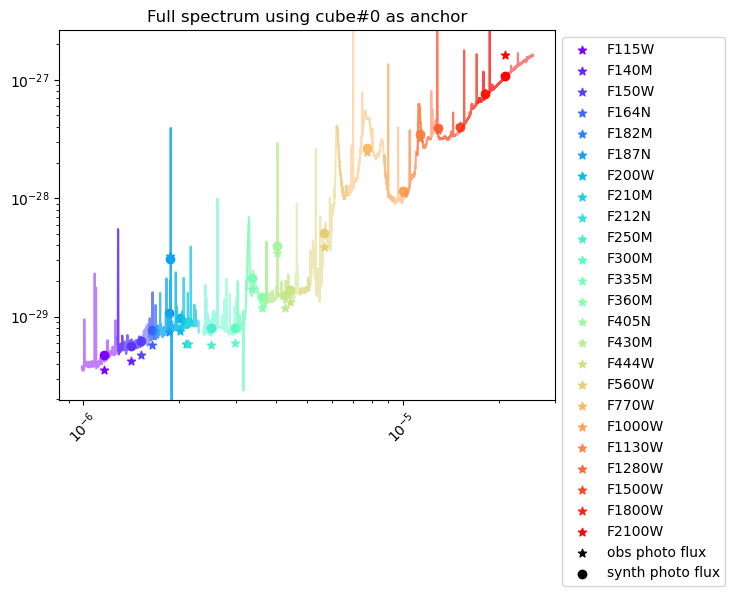

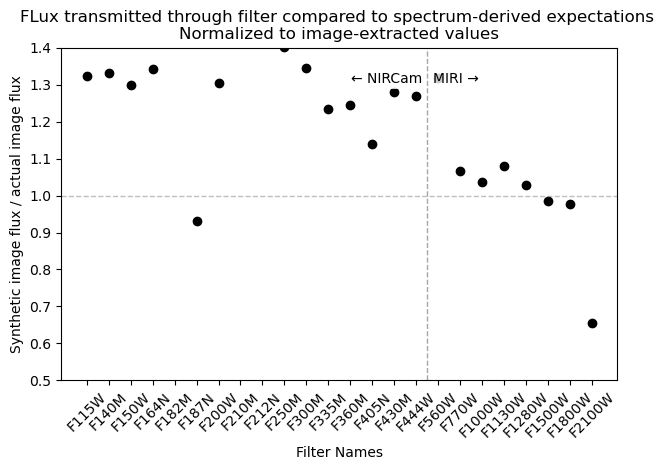

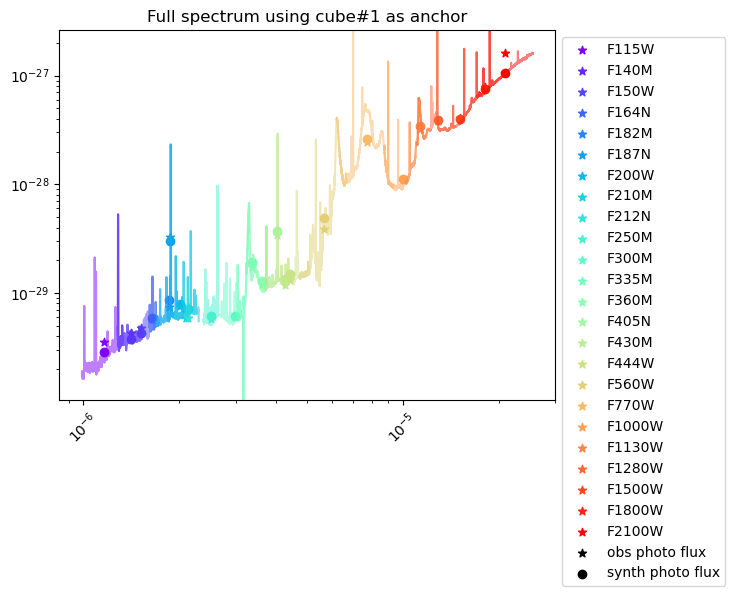

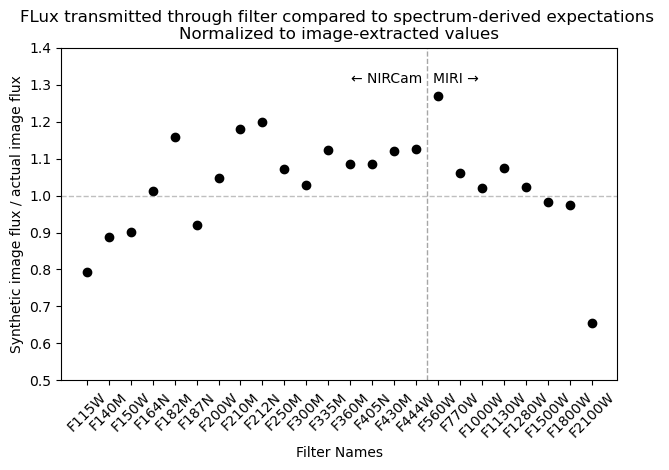

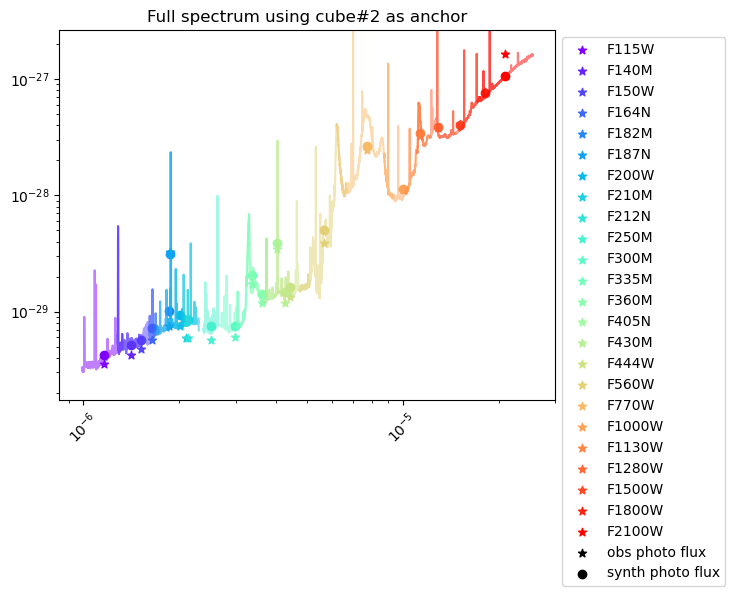

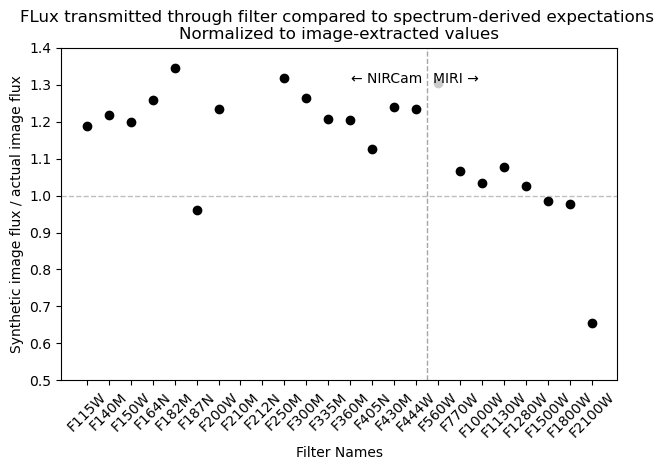

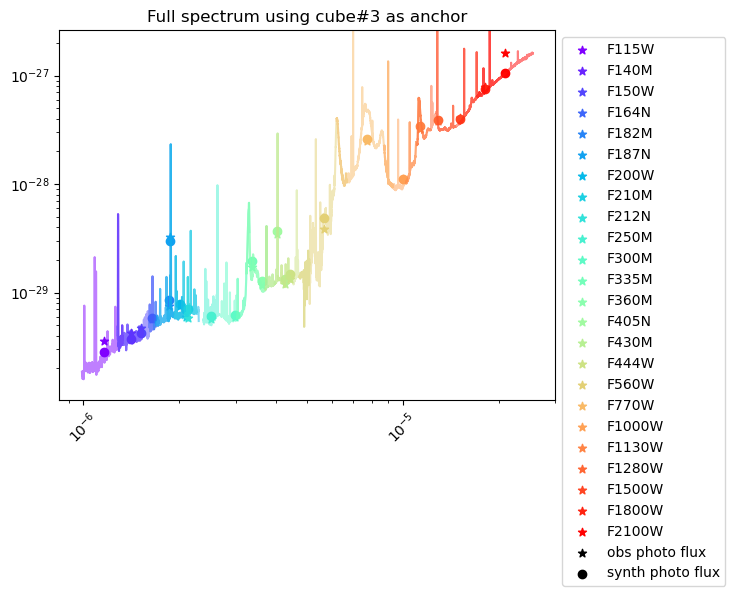

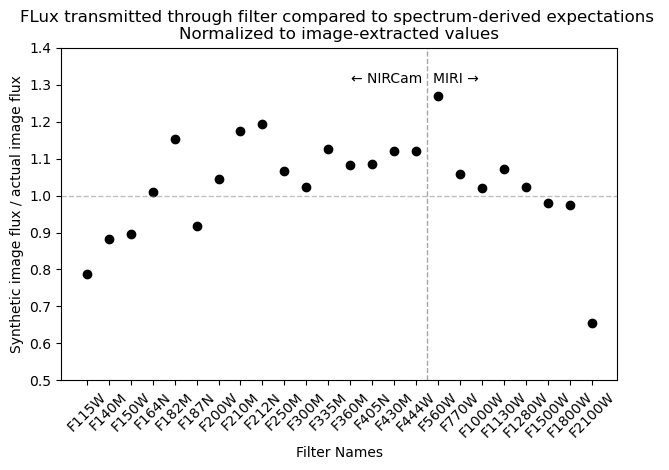

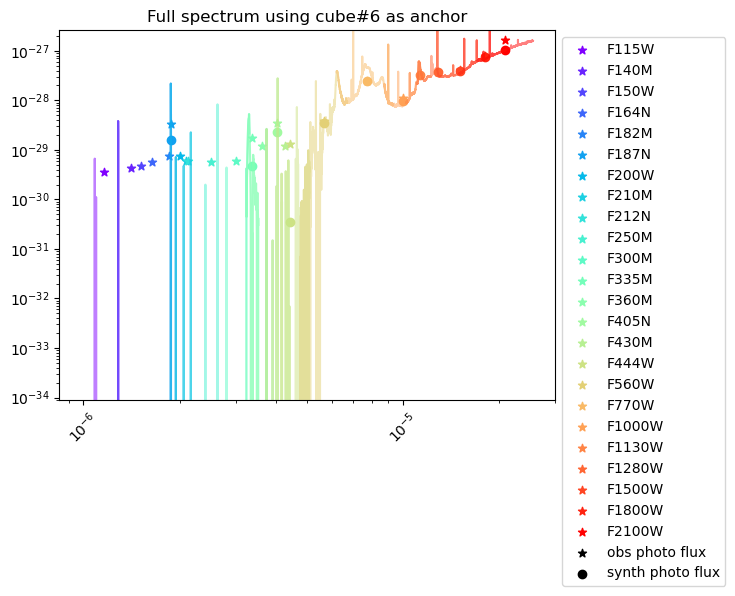

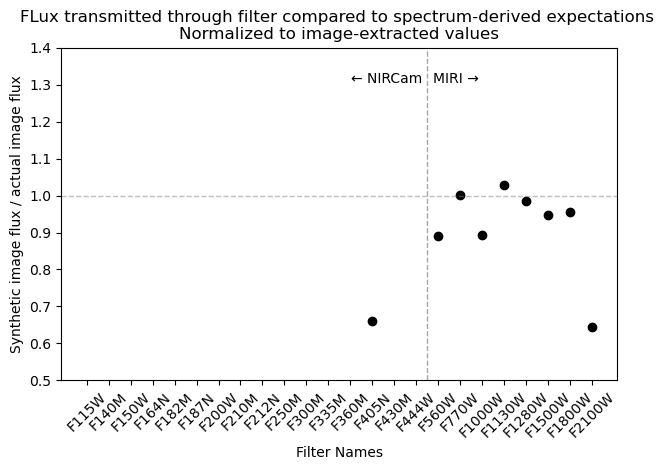

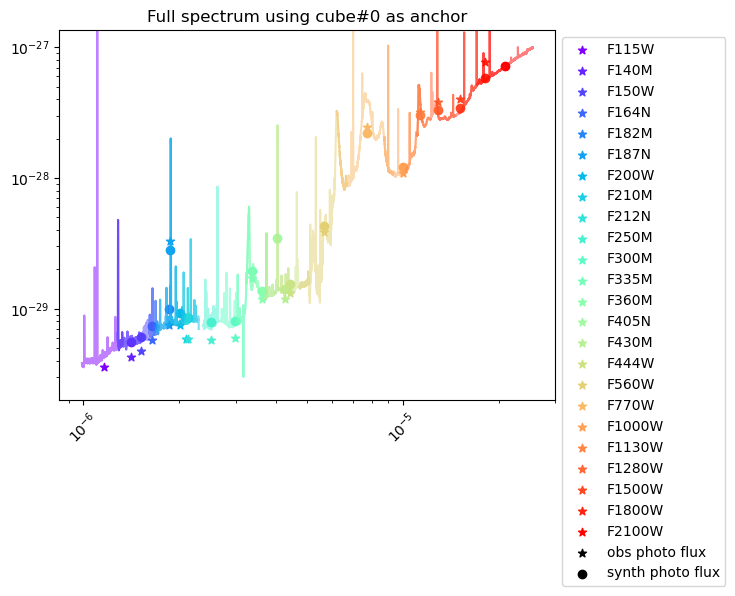

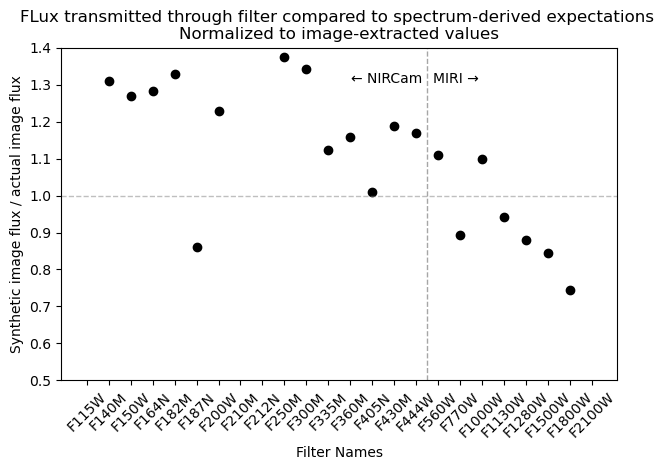

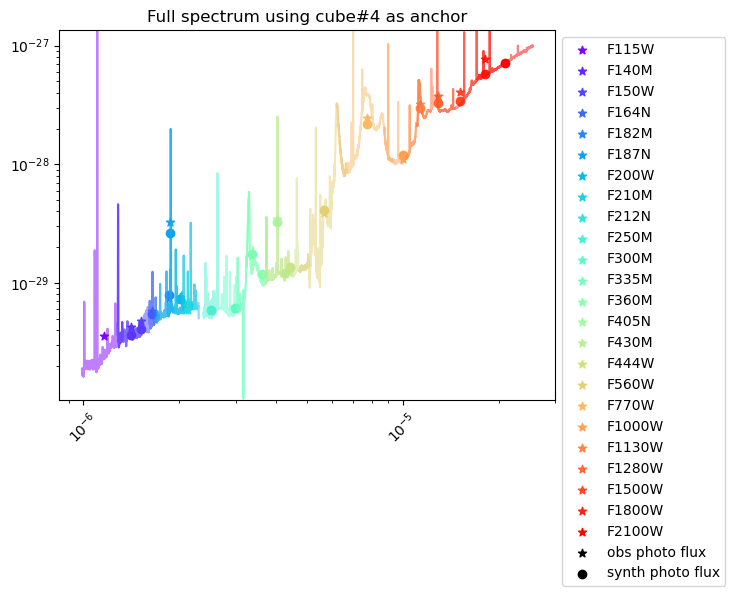

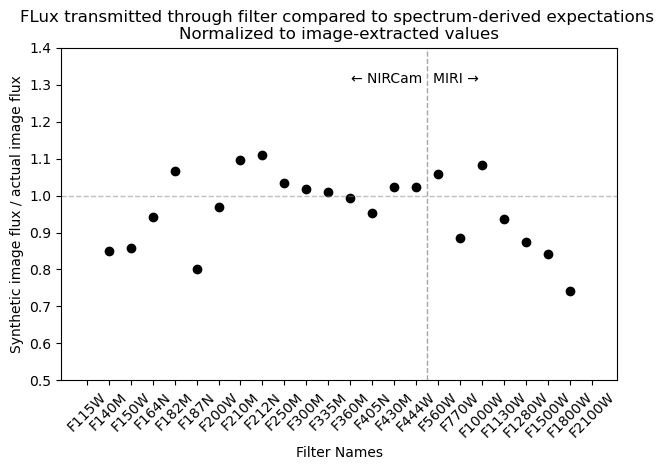

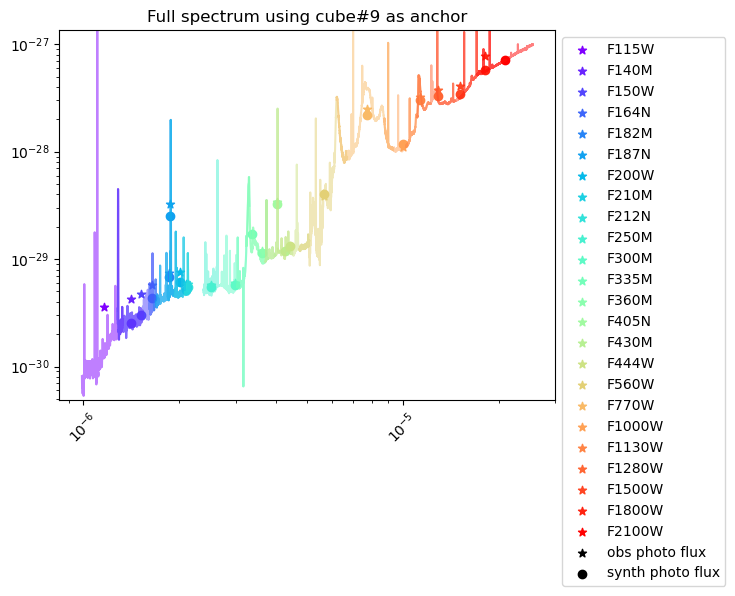

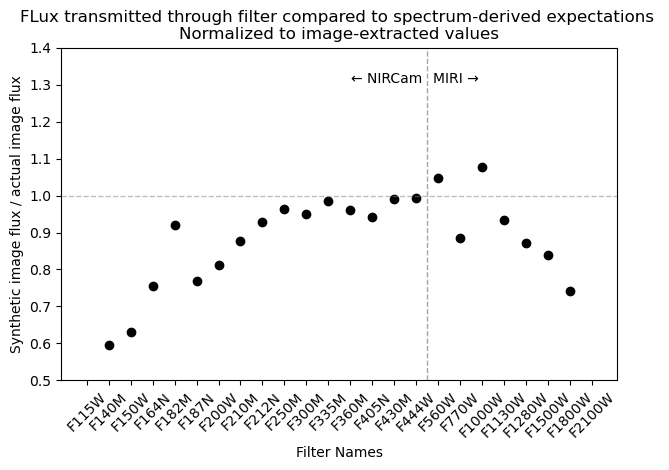

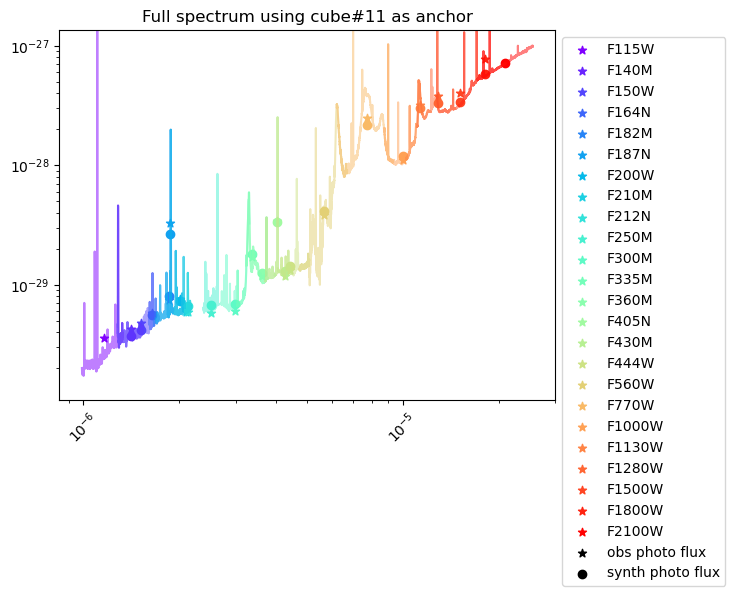

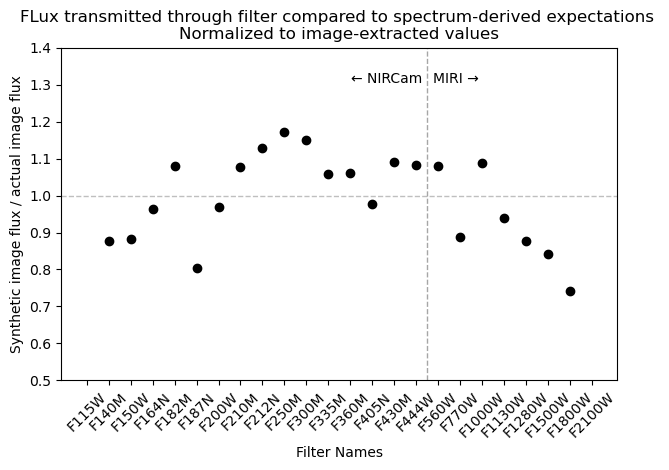

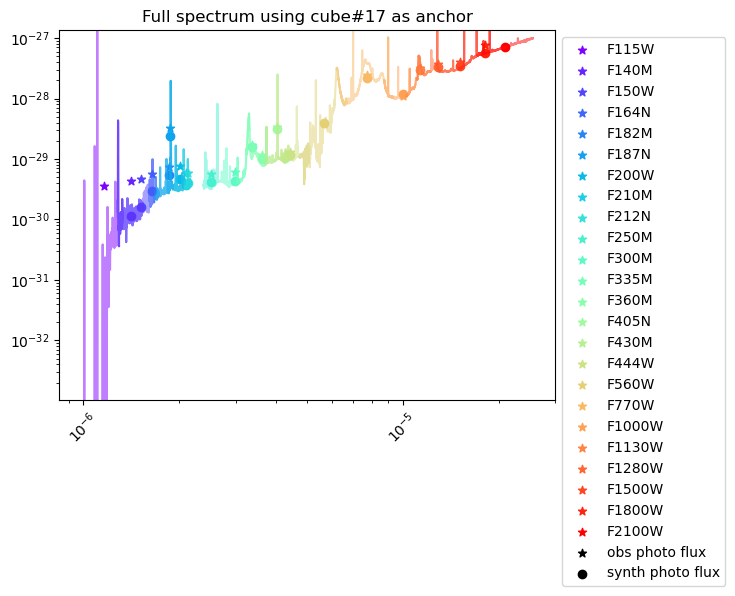

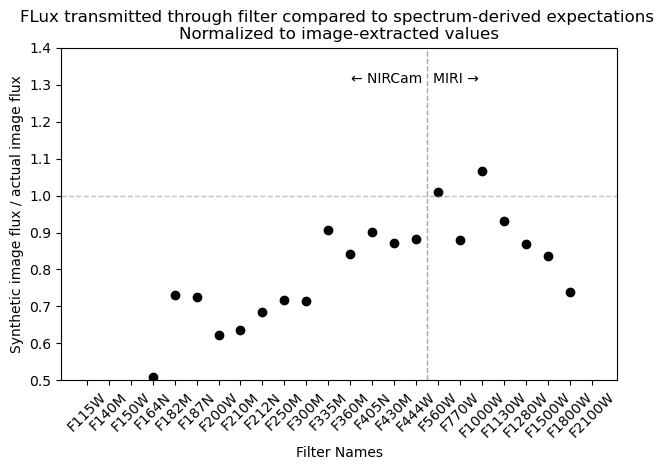

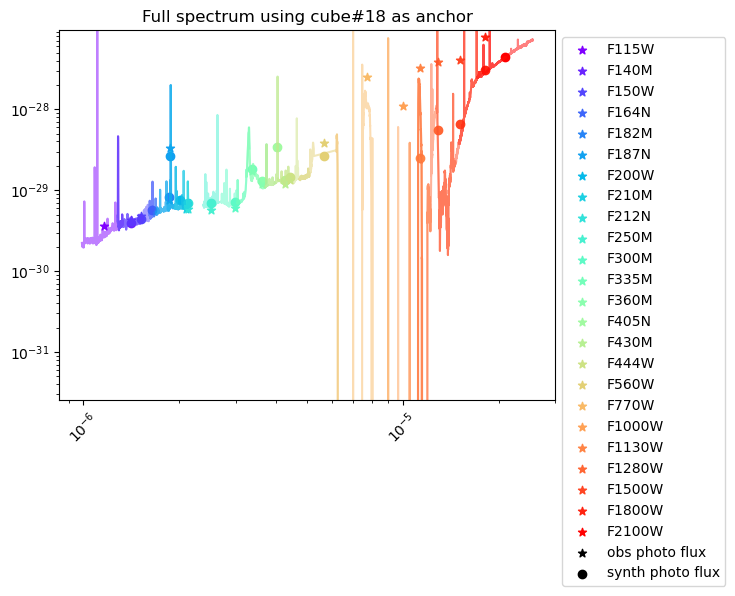

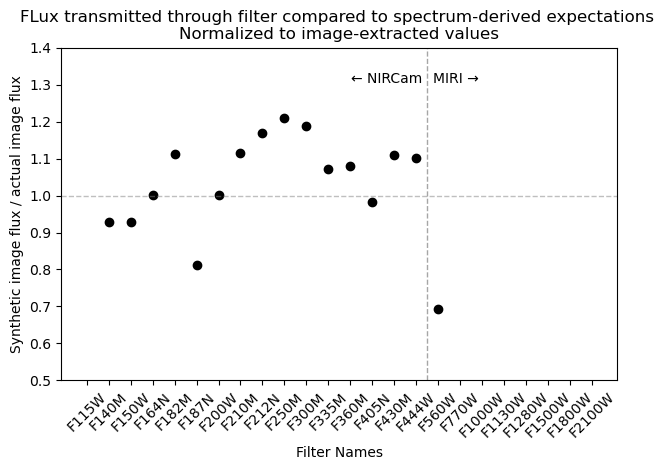

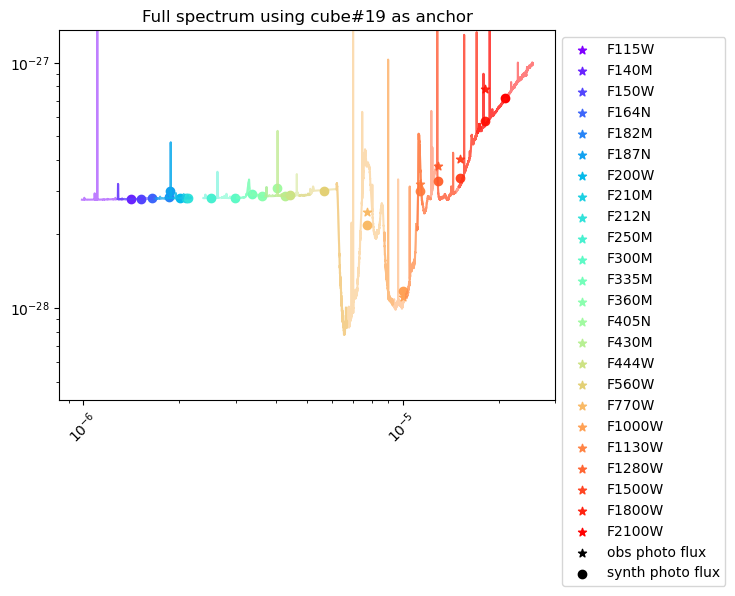

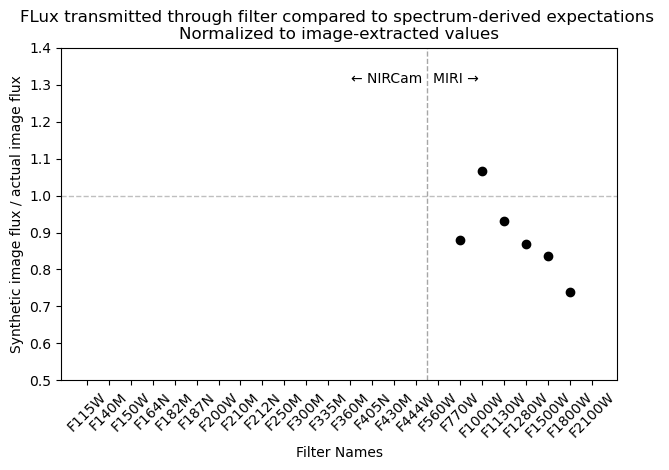

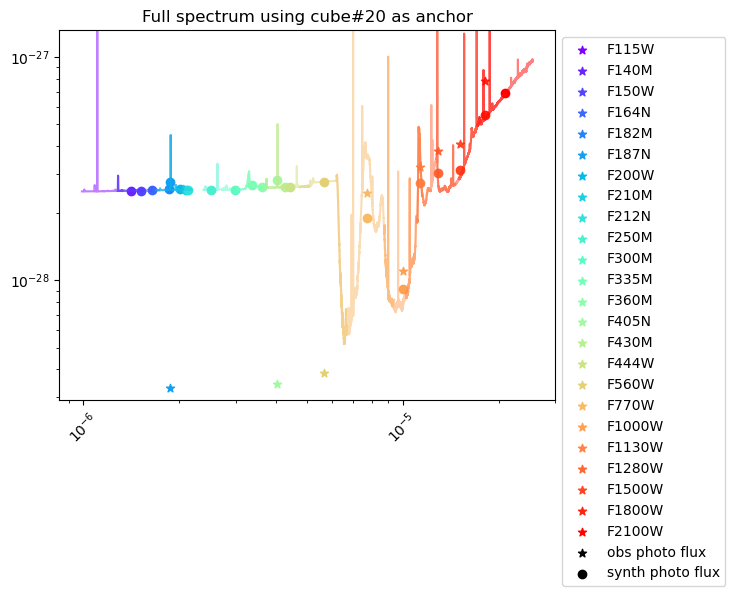

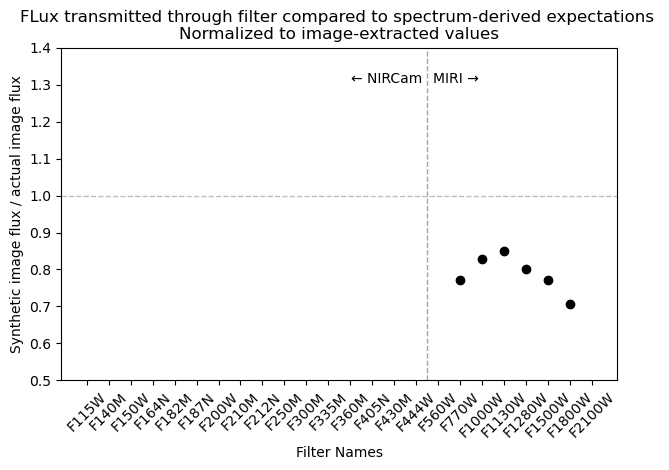

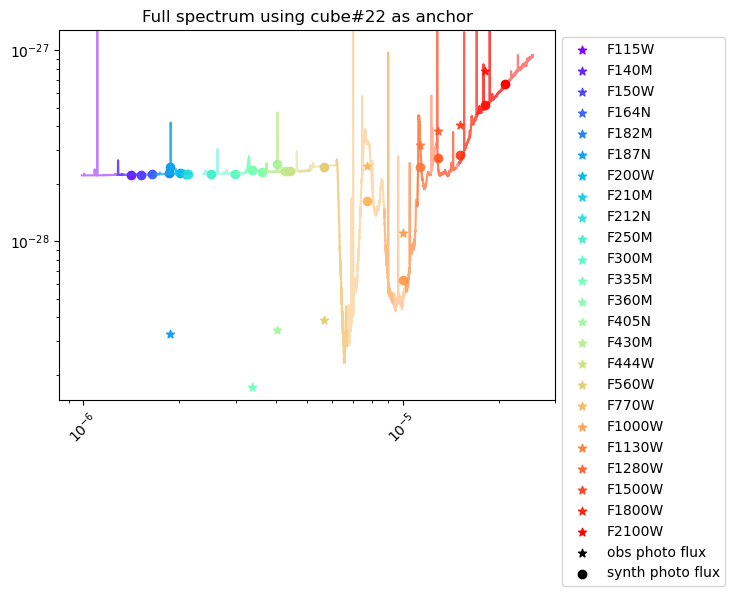

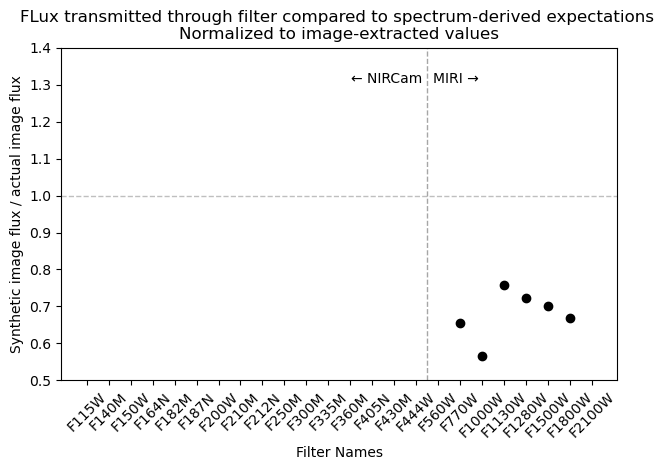

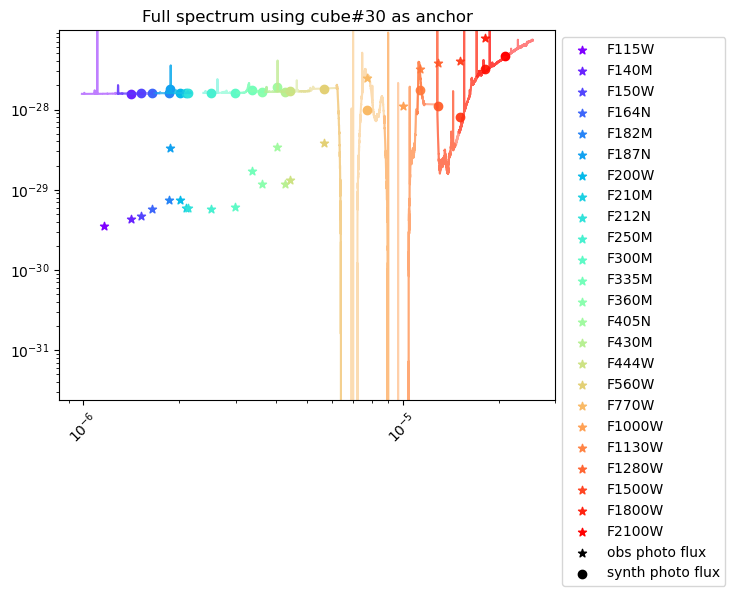

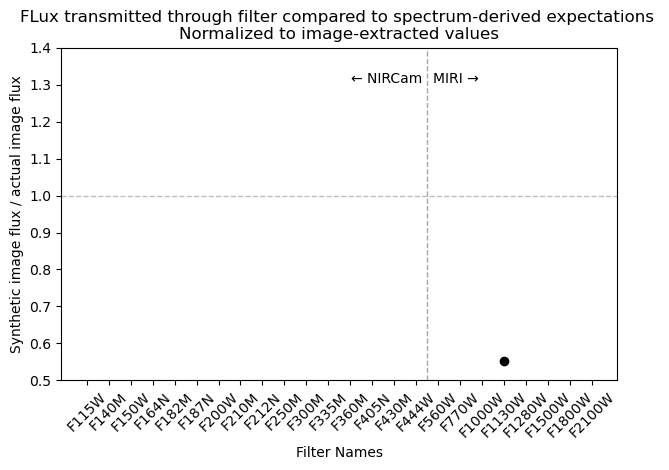

In [23]:
#These are rough drafts for interesting plots
unconvolved_idx = [0,1,2,3,6]
conv21_idx = [0, 4, 9, 11, 17, 18, 19, 20, 22, 30]
for idx in unconvolved_idx:
    file = full_raw_specs[idx]
    show_spec_and_all_filters(file, image_files, locations[0], radius)
for idx in conv21_idx:
    file = full_conv_specs[idx]
    show_spec_and_all_filters(file, image_files, locations[0], radius)


A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Stitching RIGHT: anchor → file 1
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Stitching LEFT: file 0 → anchor
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
A total of 1 were detected

ValueError: x and y must be the same size

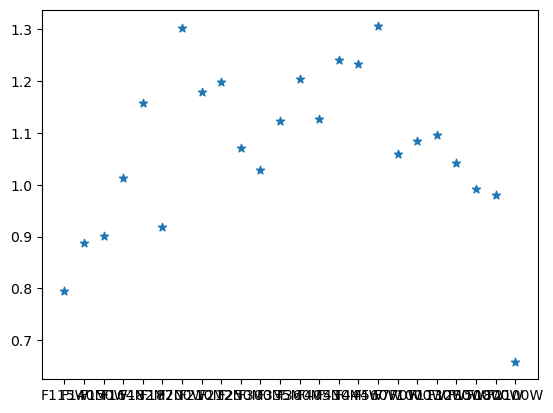

In [107]:
#This cell should recreate all noteable figures
y_min = 1.5
y_max = 0.5

filter_names = [extract_filter_name(filter_file).upper() for filter_file in filter_files]
raw_data = []
conv_data = []
raw_data_alt = []
conv_data_alt = []
for f, filter_file in enumerate(filter_files):
    filter_name = extract_filter_name(filter_file).upper()
    filter_data = []
    with open(filter_file, 'r') as fil:
        header = fil.readline().strip().split()
        for line in fil:
            data_line = line.strip().split()
            filter_data.append(data_line)
    if len(filter_data) < 2:
        print(f"Filter file {filter_file} seems empty or malformed.")

    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = np.array([try_float(row[0]) * 1e-10 for row in filter_T])
    filter_trans = np.array([try_float(row[1]) for row in filter_T])
    filter_start, filter_end = [x.value for x in get_filter_wl_range(filter_name)]
    raw_photo_file = [phot for phot in image_files if extract_filter_name(phot).upper()==filter_name][0]
    raw_photo_flux = get_image_flux(raw_photo_file, locations[0], radius, replace_negatives = False)
    filter_mean = jwst_means[filter_name].value
    if extract_filter_number(filter_name) < 200:
        raw_ifu_data = {}
        conv_ifu_data = {}
        raw_ifu_data['wavelength'], raw_ifu_data['intensity'] = np.load('Data_files/misc_data/Updated_flux_calibration/loc0_rad1p25_anchor1.npy')
        raw_synth_flux = get_Fnu_transmission(raw_ifu_data['intensity'], raw_ifu_data['wavelength'], filter_trans, filter_wl, warnings = True)
        raw_synth_flux_alt = np.nan
        conv_ifu_data['wavelength'], conv_ifu_data['intensity'] = np.load('Data_files/misc_data/Updated_flux_calibration/loc0_rad1p25_conv21_anchor4.npy')
        raw_data_alt.append(np.nan)
        conv_data_alt.append(np.nan)
    elif len(which_raw_fits(filter_name)) < 2:
        raw_ifu_data = get_IFU_spectrum(which_raw_fits(filter_name)[0], locations[0], radius, replace_negatives=False)
        raw_synth_flux = get_Fnu_transmission(raw_ifu_data['intensity'], raw_ifu_data['wavelength'], filter_trans, filter_wl, warnings = True)
        raw_synth_flux_alt = np.nan
        wavelength = raw_ifu_data['wavelength']
        flux = raw_ifu_data['intensity']
        conv_data_alt.append(np.nan)

    elif len(which_raw_fits(filter_name)) > 1:
        raw_ifu_data = stitch_spectra(which_raw_fits(filter_name), locations[0], radius, replace_negatives = False, anchor_idx = 0)
        raw_ifu_data_alt = stitch_spectra(which_raw_fits(filter_name), locations[0], radius, replace_negatives = False, anchor_idx = 1)
        raw_synth_flux = get_Fnu_transmission(raw_ifu_data['intensity'], raw_ifu_data['wavelength'], filter_trans, filter_wl, warnings = True)
        raw_synth_flux_alt = get_Fnu_transmission(raw_ifu_data_alt['intensity'], raw_ifu_data_alt['wavelength'], filter_trans, filter_wl, warnings = True)
    raw_data.append(raw_synth_flux/raw_photo_flux)
    raw_data_alt.append(raw_synth_flux_alt/raw_photo_flux)
plt.scatter(filter_names, raw_data, marker = '*', label = 'anchored to blue')
plt.scatter(filter_names, raw_data_alt, marker = '*', label = 'anchored to red')

plt.ylim(y_min, y_max)
plt.xticks(rotation = 45)
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.title(title)
plt.show()

# Add NIRCam label to the left
plt.text(15.25, text_y_pos, "← NIRCam", 
         ha='right', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)

# Add MIRI label to the right
plt.text(15.75, text_y_pos, "MIRI →", 
         ha='left', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)
plt.xlabel('Filter Names')
plt.ylabel('Synthetic image flux / actual image flux')
plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to image-extracted values")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

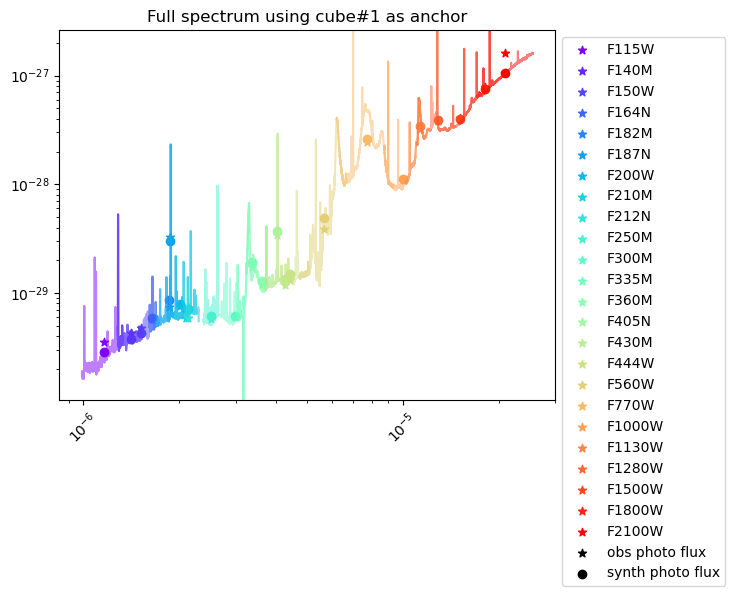

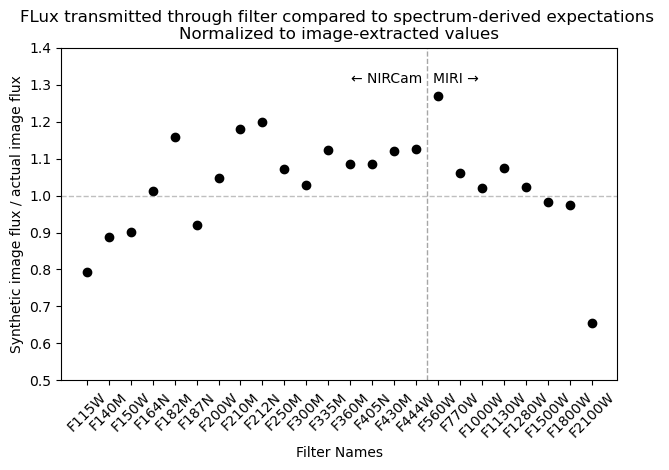

In [52]:
show_spec_and_all_filters(full_specs[1], image_files, locations[0], radius)

In [55]:
[phot for phot in image_files if extract_filter_name(phot).upper()=='F200W']

['Data_files/Image_files/ngc5194_nircam_lv3_f200w_i2d.fits']

Newly combined spectrum goes from 9.887620289518963e-07 to 1.3283860351366454e-06
1.8433153585740266e-30  through  1.4036972236723906e-29
Newly combined spectrum goes from 1.2819580342911646e-06 to 1.5363580389239353e-06
1.8433153585740266e-30  through  1.4036972236723906e-29
Newly combined spectrum goes from 1.279414034244837e-06 to 1.723978042340604e-06
1.8433153585740266e-30  through  1.4036972236723906e-29
Newly combined spectrum goes from 1.608862040244275e-06 to 1.6807300415530328e-06
1.8433153585740266e-30  through  1.499914076213128e-29
Newly combined spectrum goes from 1.6626499667181632e-06 to 2.0453099806909446e-06
1.8433153585740266e-30  through  1.8755500061102757e-29
Newly combined spectrum goes from 1.8333099729497916e-06 to 1.91386997589143e-06
1.8433153585740266e-30  through  1.7182734774002916e-28


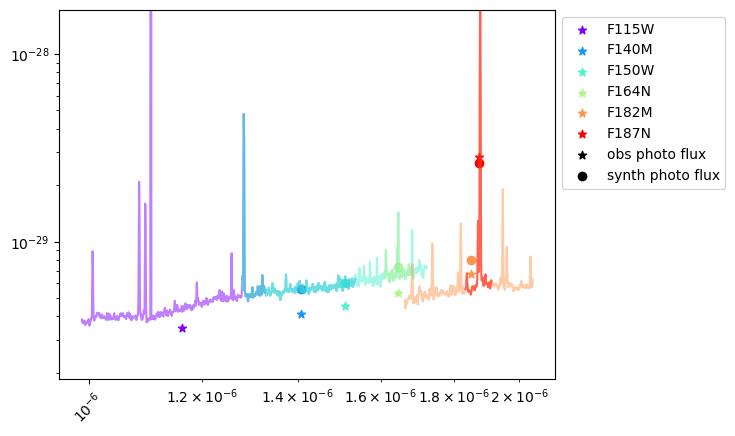

In [180]:
show_spec_and_all_filters(conv_21um_filter_loc0_ifu_files, conv_21um_loc0_image_files[::-1][:6], locations[0], radius)

Newly combined spectrum goes from 1.6902099677245132e-06 to 2.298649989941623e-06
2.4404400491299994e-30  through  1.9063129098002185e-29
Newly combined spectrum goes from 1.930829976510722e-06 to 2.2657899887417443e-06
2.4404400491299994e-30  through  1.9127139794116016e-29
Newly combined spectrum goes from 2.0792299819295295e-06 to 2.1640299850259906e-06
2.4404400491299994e-30  through  1.9127139794116016e-29
Newly combined spectrum goes from 2.3749699927284383e-06 to 2.6569300030241722e-06
2.312676191995315e-30  through  1.9127139794116016e-29


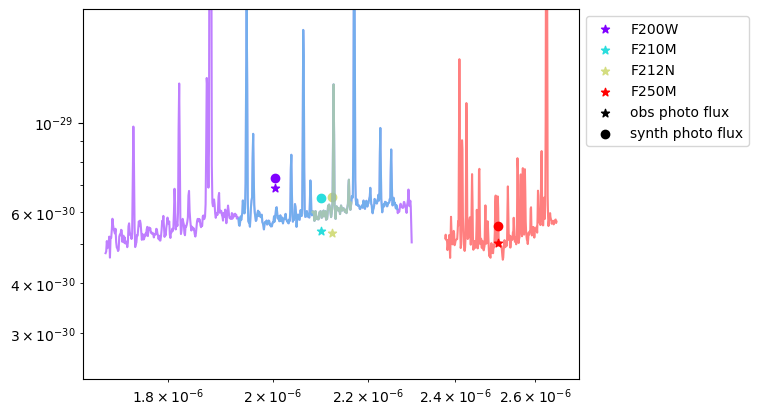

In [181]:
show_spec_and_all_filters(conv_21um_filter_loc0_ifu_files, conv_21um_loc0_image_files[::-1][6:10], locations[0], radius)


Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by -1.4187631785004646e-30
This corresponds to a correction of -0.20986635172327145
Newly combined spectrum goes from 2.700390004611108e-06 to 3.3148148878826756e-06
2.3659057612740427e-30  through  6.797219903334615e-29
Newly combined spectrum goes from 3.026624886377249e-06 to 3.7802148903138e-06
2.3659057612740427e-30  through  7.319529513078279e-29
Newly combined spectrum goes from 3.241424887499306e-06 to 3.989644891407806e-06
2.3659057612740427e-30  through  7.322431923076633e-29
Newly combined spectrum goes from 3.9681648912956e-06 to 4.1364248921745455e-06
2.3659057612740427e-30  through  1.7055015422418514e-28
Newly combined spectrum goes from 4.063034891791176e-06 to 4.510534894128796e-06
2.3659057612740427e-30  through  1.7055015422418514e-28
Newly combined spectrum goes from 3.7121948899584815e-06 to 5.101234897214453e-06
2.3659057612740427e-30  through  1.7

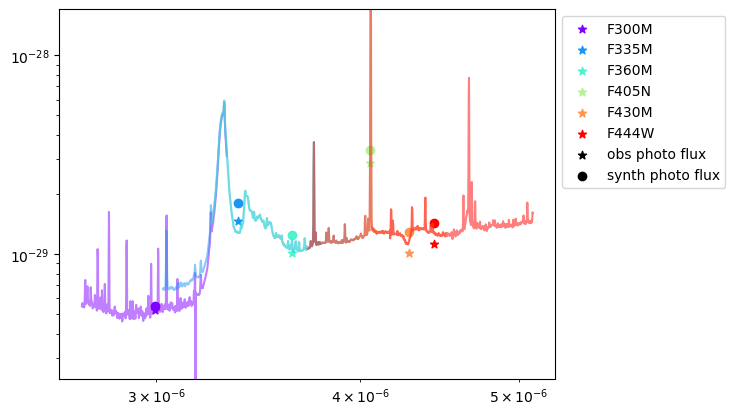

In [182]:
show_spec_and_all_filters(conv_21um_filter_loc0_ifu_files, conv_21um_loc0_image_files[::-1][10:16], locations[0], radius)


Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by -3.407090761322364e-30
This corresponds to a correction of -0.17413647244747668
Newly combined spectrum goes from 4.9004000953573265e-06 to 6.69640004998655e-06
filter goes from 4.753e-06 to 6.696e-06, but provided Fnu array goes from 4.9004000953573265e-06 to 6.69640004998655e-06
4.3186326451143686e-30  through  5.891727797252036e-28

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 1.2009126330851488e-29
This corresponds to a correction of 0.02344311227838717
Newly combined spectrum goes from 6.207600062334677e-06 to 9.329350233834701e-06
4.3186326451143686e-30  through  8.319124864661648e-28
Newly combined spectrum goes from 8.741750232235063e-06 to 1.1515950239787342e-05
4.3186326451143686e-30  through  9.39788493145496e-28

Stitching RIGHT: file 1 to combined
Stitching these sections required

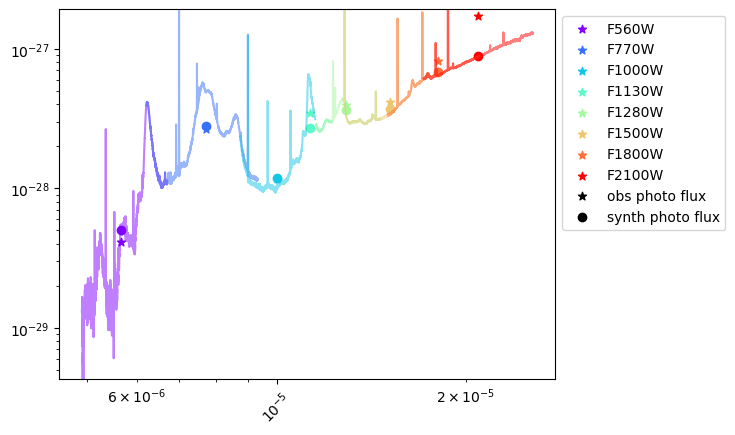

In [183]:
show_spec_and_all_filters(conv_21um_filter_loc0_ifu_files, conv_21um_loc0_image_files[::-1][16:24], locations[0], radius*1.3)

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total 

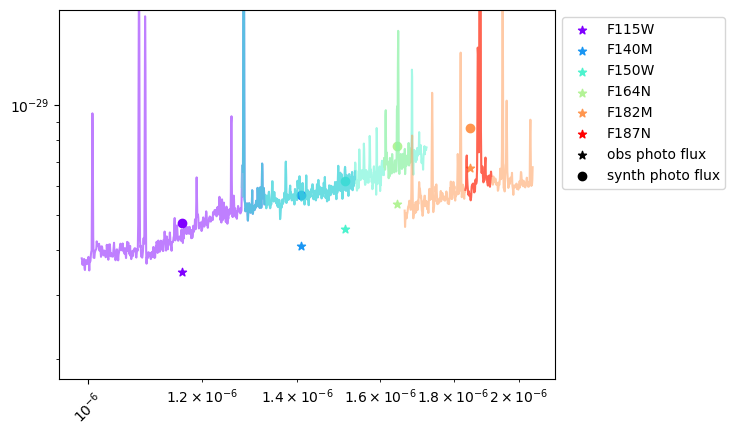

In [184]:
show_spec_and_all_filters(full_raw_ifu_files, conv_21um_loc0_image_files[::-1][:6], locations[0], radius)

Newly combined spectrum goes from 9.887620289518963e-07 to 1.3283860351366454e-06
1.8433153585740266e-30  through  1.4036972236723906e-29
Newly combined spectrum goes from 1.2819580342911646e-06 to 1.5363580389239353e-06
1.8433153585740266e-30  through  1.4036972236723906e-29
Newly combined spectrum goes from 1.279414034244837e-06 to 1.723978042340604e-06
1.8433153585740266e-30  through  1.4036972236723906e-29
Newly combined spectrum goes from 1.608862040244275e-06 to 1.6807300415530328e-06
1.8433153585740266e-30  through  1.499914076213128e-29
Newly combined spectrum goes from 1.6626499667181632e-06 to 2.0453099806909446e-06
1.8433153585740266e-30  through  1.8755500061102757e-29
Newly combined spectrum goes from 1.8333099729497916e-06 to 1.91386997589143e-06
1.8433153585740266e-30  through  1.7182734774002916e-28


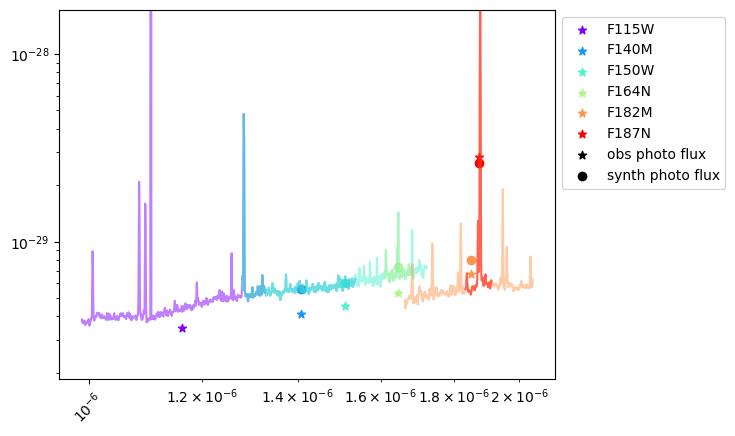

In [185]:
show_spec_and_all_filters(conv_21um_filter_loc0_ifu_files, conv_21um_loc0_image_files[::-1][:6], locations[0], radius)

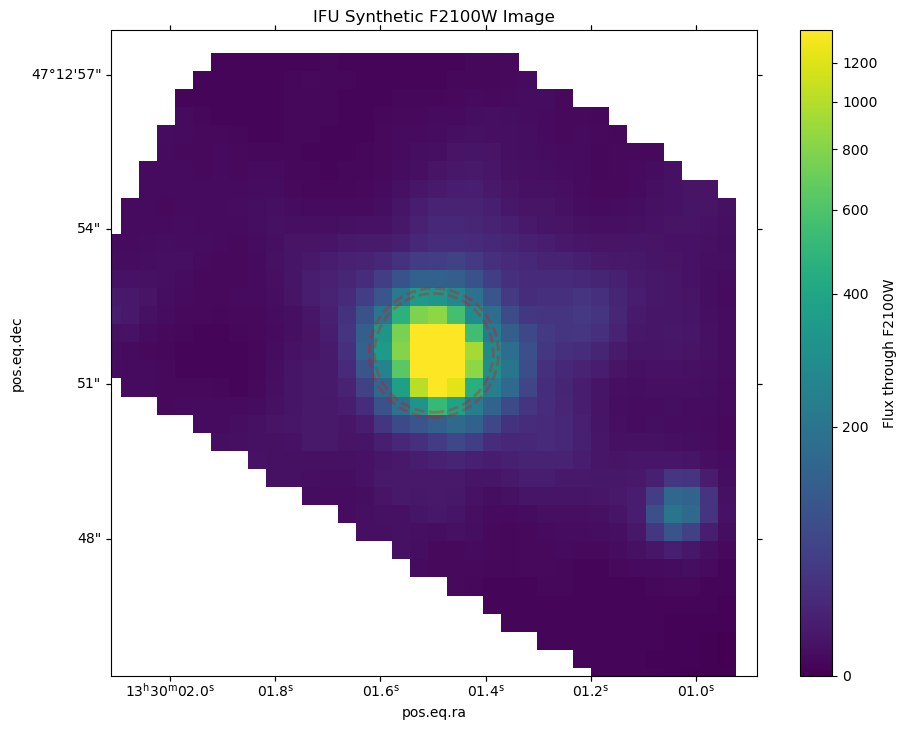

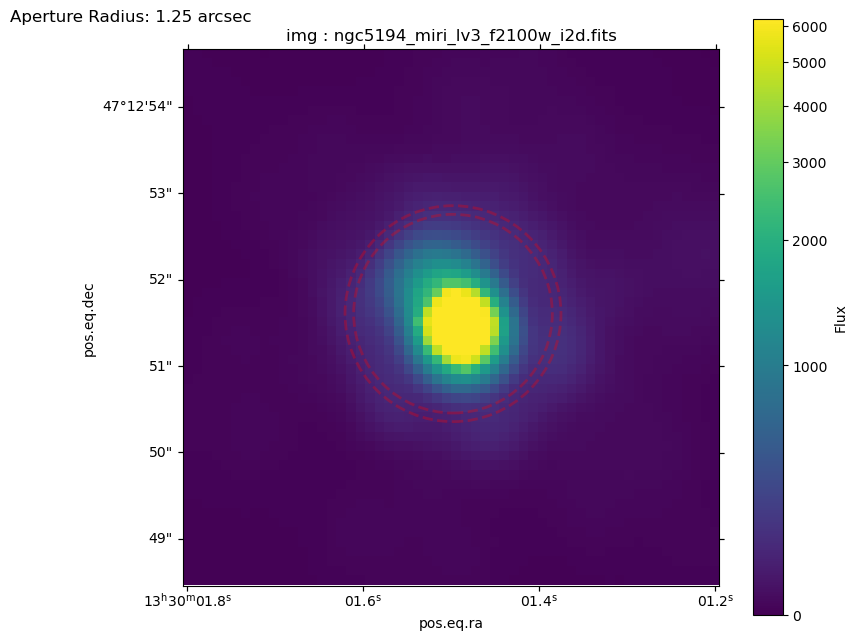

In [48]:
show_IFU('Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch4-shortmediumlong_s3d.fits', 'F2100W', locations[0], 1.25*u.arcsec, zoom_scale=5)
show_image(image_files[-1], locations[0], 1.25*u.arcsec, zoom_scale=5)

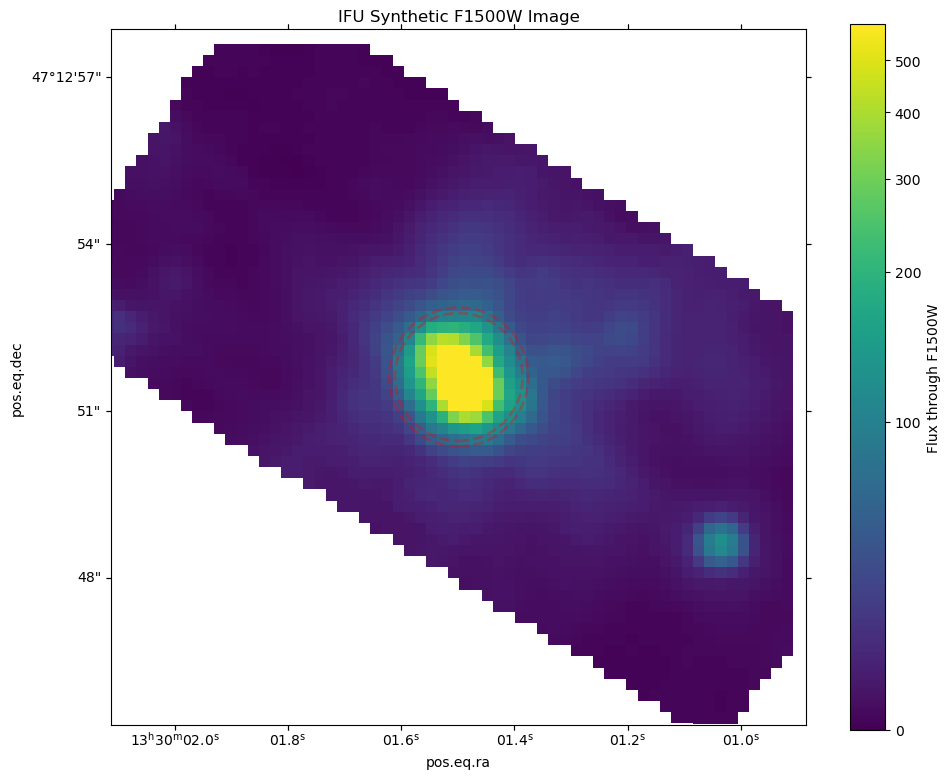

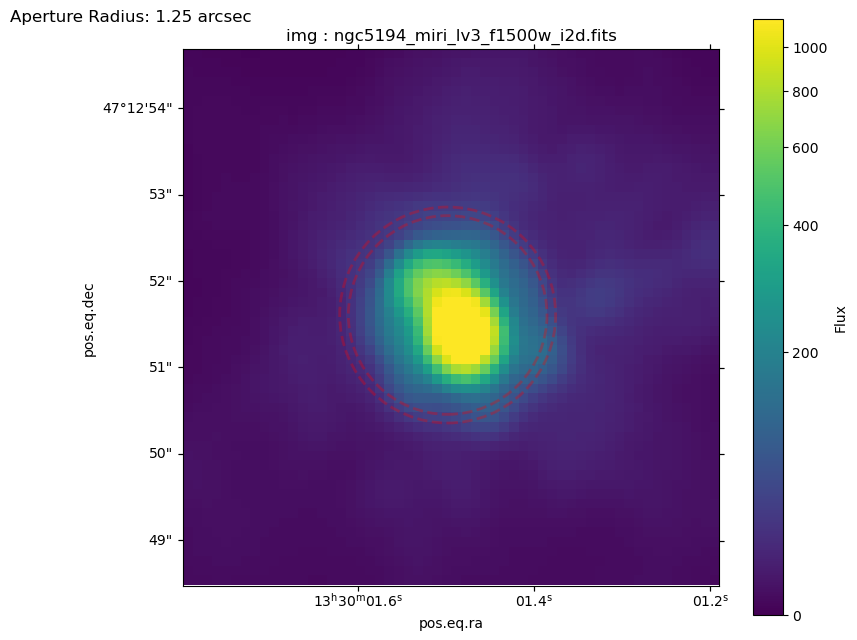

In [115]:
show_IFU('Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch3-shortmediumlong_s3d.fits', 'F1500W', locations[0], 1.25*u.arcsec, zoom_scale=5)
show_image(image_files[-3], locations[0], 1.25*u.arcsec, zoom_scale=5)

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total 

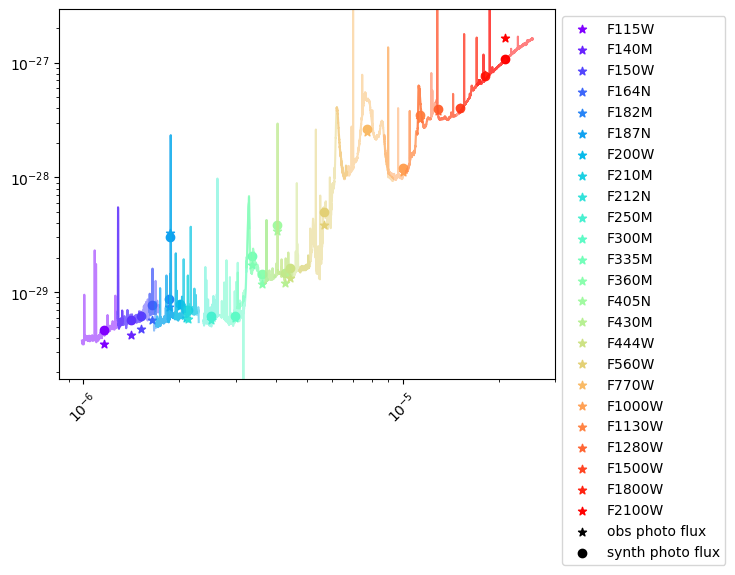

In [193]:
show_spec_and_all_filters(full_raw_ifu_files, image_files, locations[0], radius)

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total 

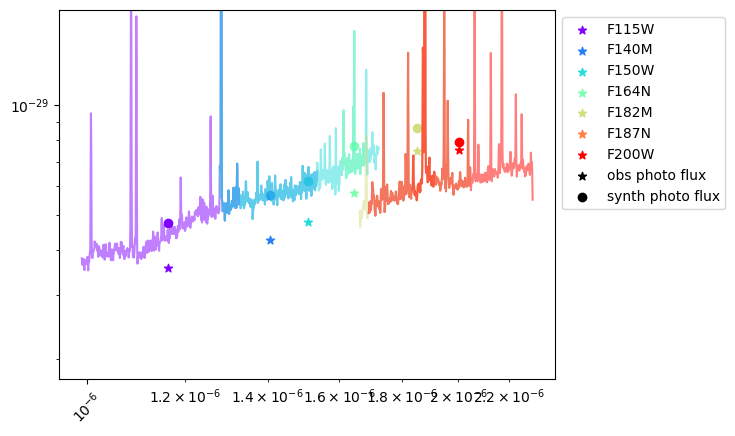

In [194]:
show_spec_and_all_filters(full_raw_ifu_files, image_files[:7], locations[0], radius)

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 1.8899740453634867e-06
1.755500651689621e-30  through  1.6434096595777137e-29
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_n

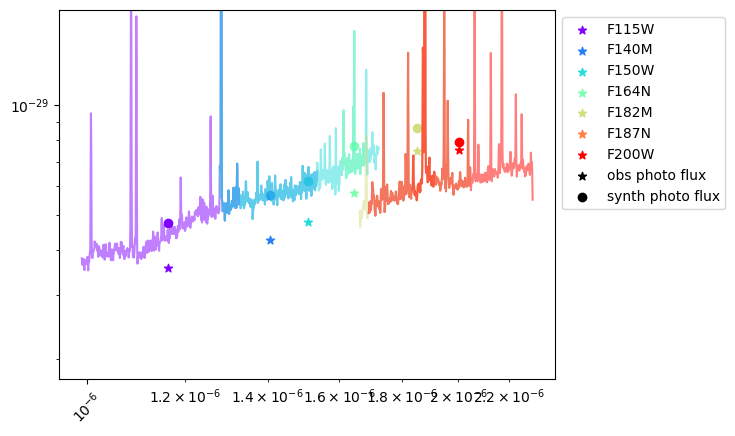

In [3]:
show_spec_and_all_filters(full_raw_ifu_files, image_files[:7], locations[0], radius)

In [134]:
sed_wl, sed_flux = np.load('Data_files/misc_data/Updated_flux_calibration/full_spectrum_loc0_rad1p25.npy')
loc = locations[0]
image_file = image_files[1]
hdu = fits.open(image_file)["SCI"]
image_data = hdu.data
image_header = hdu.header
image_wcs = WCS(image_header, naxis=2)
# Convert location to pixels
loc_sky = SkyCoord(ra=loc[0]*u.deg, dec=loc[1]*u.deg, frame='icrs')
cutout = Cutout2D(data = image_data, position = loc_sky, size = (radius*5, radius*5), wcs = image_wcs)


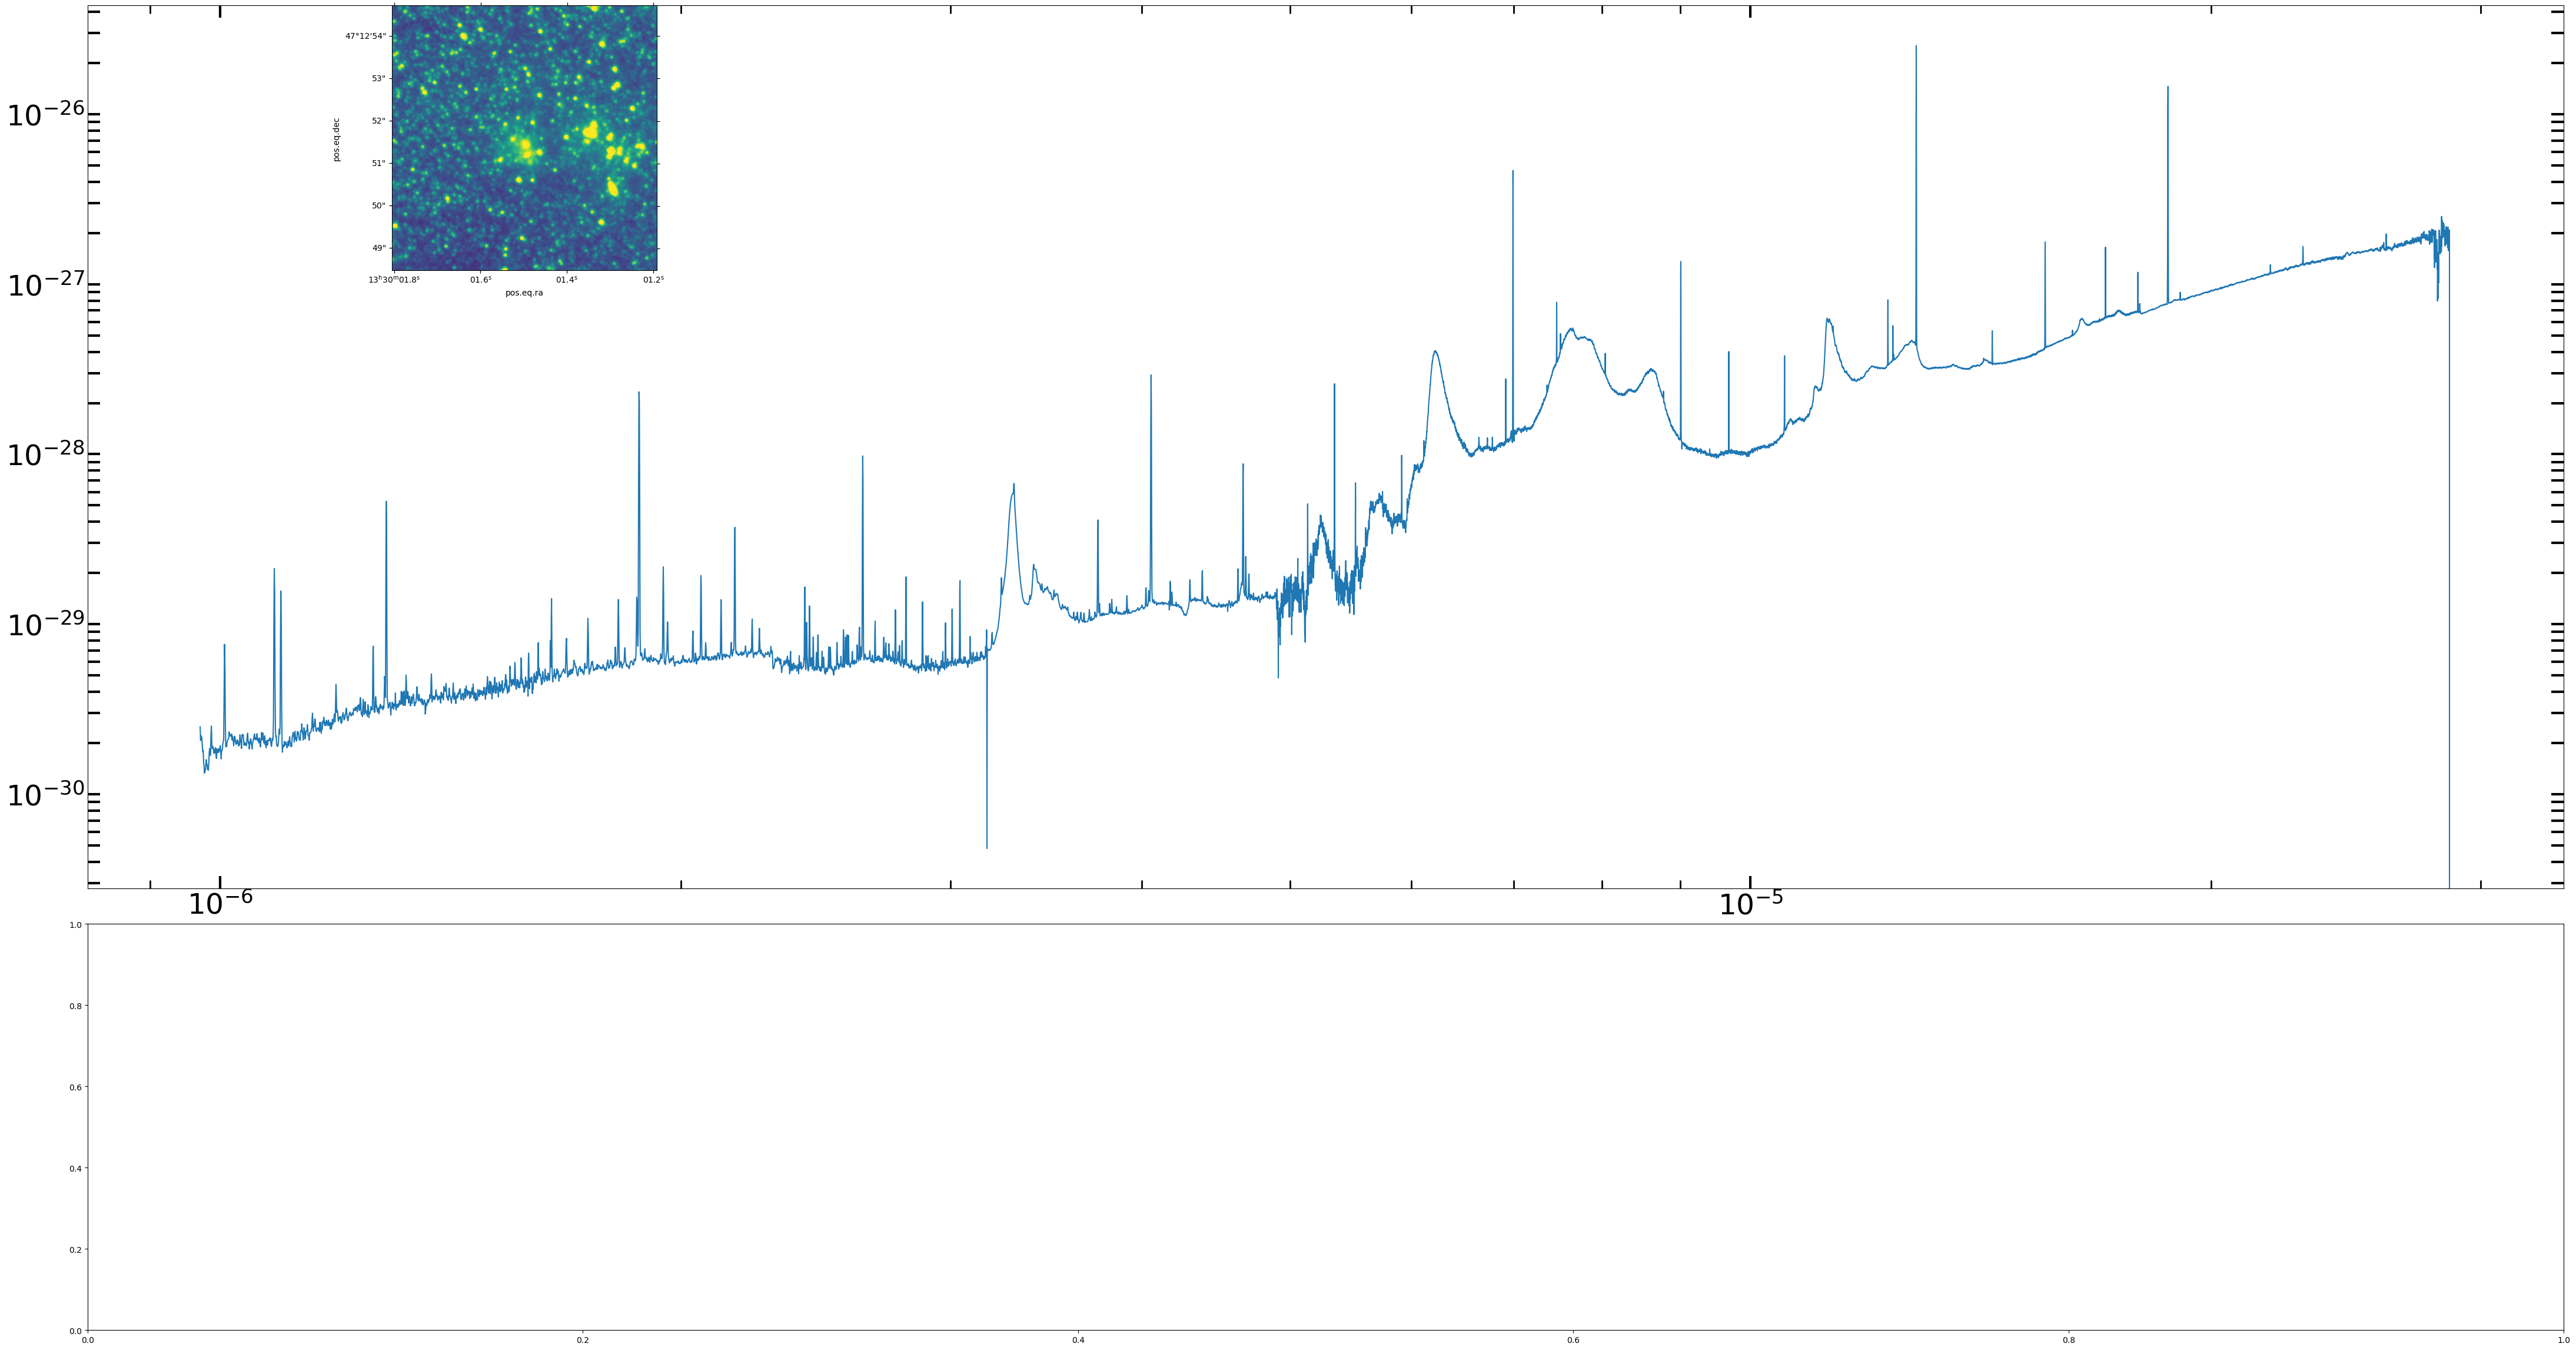

In [146]:
fig = plt.figure(figsize = (45,30))
fontsize_sm = 35
fontsize_lg = 45
#Spectrum plot
ax_spec = fig.add_axes((0.06, 0.3, 0.935, 0.5))
ax_spec.plot(sed_wl, sed_flux)
ax_spec.set_xscale('log')
ax_spec.set_yscale('log')
ax_spec.tick_params(axis='x', which='minor', width=2, length=10, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_spec.tick_params(axis='x', which='major', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)
ax_spec.tick_params(axis='y', which='both', width=3, length=15, right=True, top=True, direction='in',
                   labelsize=fontsize_sm)


#ratio plot
ax_rat = fig.add_axes((0.06, 0.05, 0.935, 0.23))

#image plot
ax_image = fig.add_axes((0.15, 0.65, 0.15, 0.15), projection = cutout.wcs)
x_img, y_img = cutout.wcs.all_world2pix(loc_sky.ra, loc_sky.dec, 0)

im2 = ax_image.imshow(cutout.data, origin='lower', cmap='viridis',
            norm=ImageNormalize(cutout.data, stretch=AsinhStretch(), vmin=0, vmax=np.percentile(cutout.data, 99)))
#ax_image.add_patch(Circle((x_img, y_img), radius_pix, ec='red', fc='none', lw=2, ls='--', alpha = 0.3))
#ax_image.add_patch(Circle((x_img, y_img), in_radius_pix, ec='red', fc='none', lw=2, ls='--', alpha = 0.3))

[[202.5062429, 47.2143358],
 [202.4335225, 47.1729608],
 [202.434045, 47.1732517],
 [202.4823742, 47.1958589]]